In [1]:
import os
import cv2
import torch
import json
import torch.nn as nn
import numpy as np
from imutils import face_utils
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
import dlib

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torch.utils.data import Dataset
import os
import torch

#Load dari file simpanan hasil preproses dalam bentuk .pt
class ProcessedVideoDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_folder = pt_folder
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]
        self.file_list = sorted([
            f for f in os.listdir(pt_folder)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.pt_folder, self.file_list[idx])
        data = torch.load(file_path)

        frames = torch.stack(data['frames'])
        label = data['label']

        return frames, label

In [ ]:
from torch.utils.data import DataLoader, random_split

pt_folder = 'Dataset Deepfake Preprocessed/Preprocessed Wajah'
full_dataset = ProcessedVideoDataset(pt_folder)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomizedCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomizedCNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):  # x shape: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)         # (B*T, 3, 224, 224)
        x = self.conv_block(x)            # (B*T, 128, 14, 14)
        x = x.view(B, T, -1)              # (B, T, 128*14*14)
        x = x.mean(dim=1)                 # (B, 128*14*14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)                   # (B, num_classes)
        return x


In [12]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
num_epochs = 40
best_val_loss = float('inf')

# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/CNN_Customized_128Filter_1e-4.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 2.2930 | Train Acc: 0.4440 | Val Loss: 0.7985 | Val Acc: 0.5821
Epoch [2/40] Train Loss: 1.1420 | Train Acc: 0.5336 | Val Loss: 0.6798 | Val Acc: 0.5970
Epoch [3/40] Train Loss: 0.7026 | Train Acc: 0.5448 | Val Loss: 0.7006 | Val Acc: 0.4776
Epoch [4/40] Train Loss: 0.6877 | Train Acc: 0.5821 | Val Loss: 0.6918 | Val Acc: 0.5970
Epoch [5/40] Train Loss: 0.6989 | Train Acc: 0.5410 | Val Loss: 0.6607 | Val Acc: 0.5821
Epoch [6/40] Train Loss: 0.6760 | Train Acc: 0.5410 | Val Loss: 0.6525 | Val Acc: 0.6119
Epoch [7/40] Train Loss: 0.6460 | Train Acc: 0.6343 | Val Loss: 0.6946 | Val Acc: 0.5373
Epoch [8/40] Train Loss: 0.6661 | Train Acc: 0.5821 | Val Loss: 0.6396 | Val Acc: 0.6567
Epoch [9/40] Train Loss: 0.6608 | Train Acc: 0.5784 | Val Loss: 0.6120 | Val Acc: 0.6567
Epoch [10/40] Train Loss: 0.6703 | Train Acc: 0.5896 | Val Loss: 0.6295 | Val Acc: 0.6716
Epoch [11/40] Train Loss: 0.6208 | Train Acc: 0.6866 | Val Loss: 0.6084 | Val Acc: 0.7015
Epoch [12/40] Train

In [14]:
print(best_val_loss)

0.3554244739795799


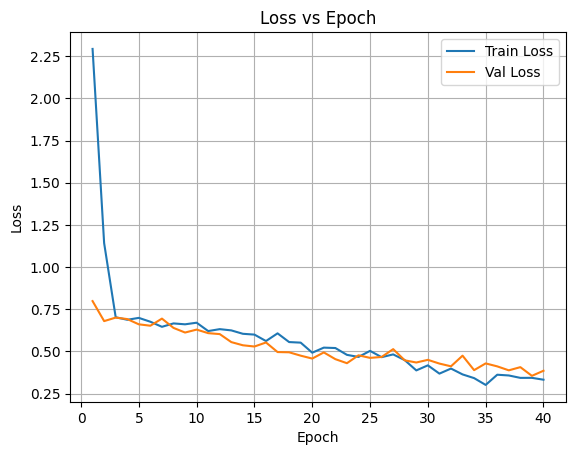

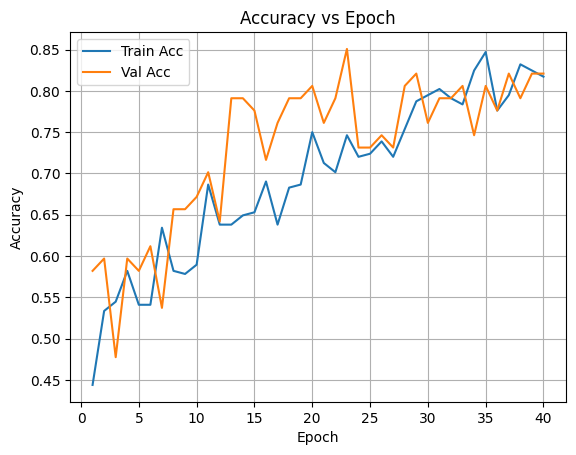

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
chnbexdyhq.pt: Predicted = R

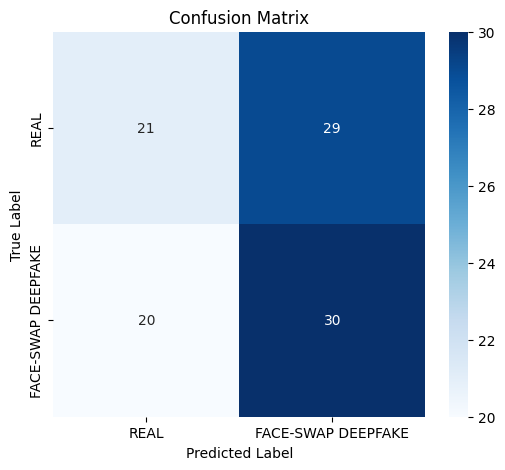


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.51      0.42      0.46        50
FACE-SWAP DEEPFAKE       0.51      0.60      0.55        50

          accuracy                           0.51       100
         macro avg       0.51      0.51      0.51       100
      weighted avg       0.51      0.51      0.51       100


📈 AUC Score: 0.5804


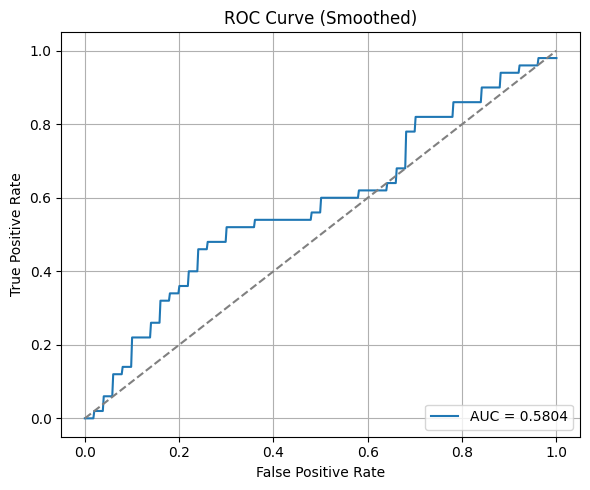

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = CustomizedCNN()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/CNN_Customized_128Filter_1e-4.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []  # Simpan probabilitas kelas DEEPFAKE (1)

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])  # Simpan prob kelas 1 (DEEPFAKE)

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Coba Learning Rate 1e-5**

In [17]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/CNN_Customized_128Filter_LR1e-5.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.8732 | Train Acc: 0.5075 | Val Loss: 0.7597 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.7811 | Train Acc: 0.4701 | Val Loss: 0.6722 | Val Acc: 0.5821
Epoch [3/40] Train Loss: 0.6928 | Train Acc: 0.5597 | Val Loss: 0.6703 | Val Acc: 0.5672
Epoch [4/40] Train Loss: 0.6959 | Train Acc: 0.5746 | Val Loss: 0.6787 | Val Acc: 0.5373
Epoch [5/40] Train Loss: 0.6914 | Train Acc: 0.5709 | Val Loss: 0.7212 | Val Acc: 0.4478
Epoch [6/40] Train Loss: 0.6894 | Train Acc: 0.5448 | Val Loss: 0.6672 | Val Acc: 0.5970
Epoch [7/40] Train Loss: 0.6807 | Train Acc: 0.5896 | Val Loss: 0.6367 | Val Acc: 0.6567
Epoch [8/40] Train Loss: 0.6696 | Train Acc: 0.5933 | Val Loss: 0.6392 | Val Acc: 0.6567
Epoch [9/40] Train Loss: 0.6586 | Train Acc: 0.6306 | Val Loss: 0.6291 | Val Acc: 0.6418
Epoch [10/40] Train Loss: 0.6340 | Train Acc: 0.6455 | Val Loss: 0.6151 | Val Acc: 0.6567
Epoch [11/40] Train Loss: 0.6333 | Train Acc: 0.6493 | Val Loss: 0.6041 | Val Acc: 0.6567
Epoch [12/40] Train

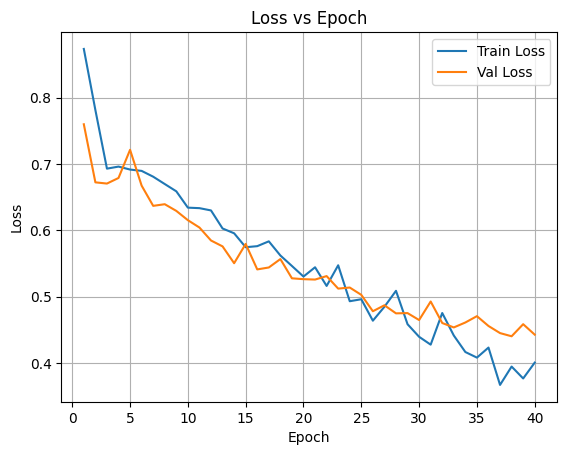

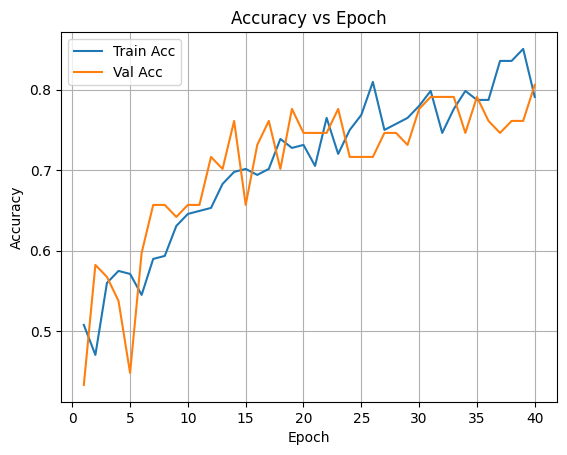

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWA

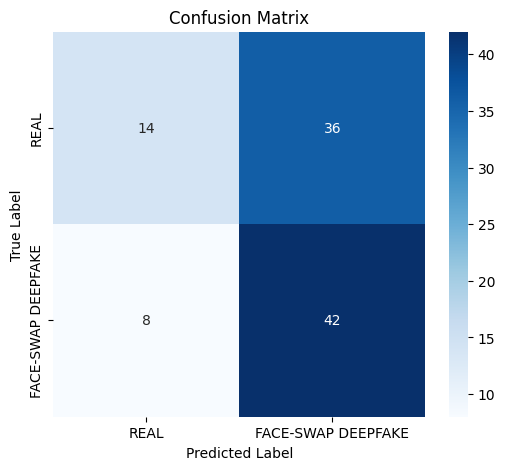


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.64      0.28      0.39        50
FACE-SWAP DEEPFAKE       0.54      0.84      0.66        50

          accuracy                           0.56       100
         macro avg       0.59      0.56      0.52       100
      weighted avg       0.59      0.56      0.52       100


📈 AUC Score: 0.6344


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


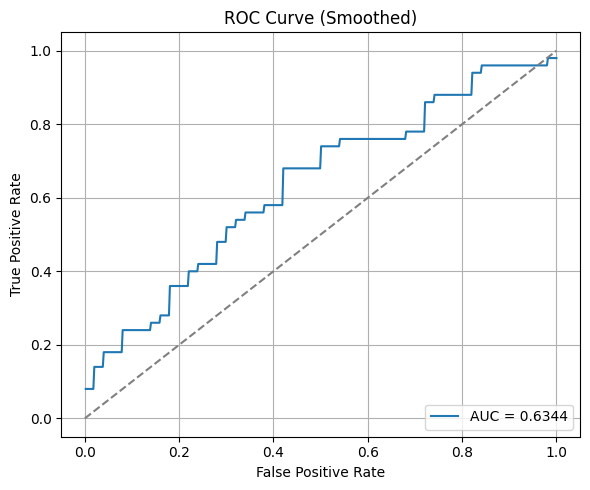

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = CustomizedCNN()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/CNN_Customized_128Filter_LR1e-5.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Coba Learning Rate 1e-3**

In [7]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/CNN_Customized_128Filter_LR1e-3.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 17.1177 | Train Acc: 0.4478 | Val Loss: 1.1980 | Val Acc: 0.5672
Epoch [2/40] Train Loss: 2.6464 | Train Acc: 0.5299 | Val Loss: 0.8398 | Val Acc: 0.5522
Epoch [3/40] Train Loss: 0.8486 | Train Acc: 0.5000 | Val Loss: 0.8581 | Val Acc: 0.4627
Epoch [4/40] Train Loss: 0.7226 | Train Acc: 0.4664 | Val Loss: 0.6974 | Val Acc: 0.4776
Epoch [5/40] Train Loss: 0.7096 | Train Acc: 0.5000 | Val Loss: 0.6852 | Val Acc: 0.4478
Epoch [6/40] Train Loss: 0.6940 | Train Acc: 0.5075 | Val Loss: 0.6880 | Val Acc: 0.4627
Epoch [7/40] Train Loss: 0.6938 | Train Acc: 0.5187 | Val Loss: 0.6977 | Val Acc: 0.4627
Epoch [8/40] Train Loss: 0.6924 | Train Acc: 0.5000 | Val Loss: 0.6842 | Val Acc: 0.4627
Epoch [9/40] Train Loss: 0.6972 | Train Acc: 0.5224 | Val Loss: 0.6951 | Val Acc: 0.4627
Epoch [10/40] Train Loss: 0.6985 | Train Acc: 0.4888 | Val Loss: 0.6816 | Val Acc: 0.4627
Epoch [11/40] Train Loss: 0.6908 | Train Acc: 0.5224 | Val Loss: 0.6736 | Val Acc: 0.4627
Epoch [12/40] Trai

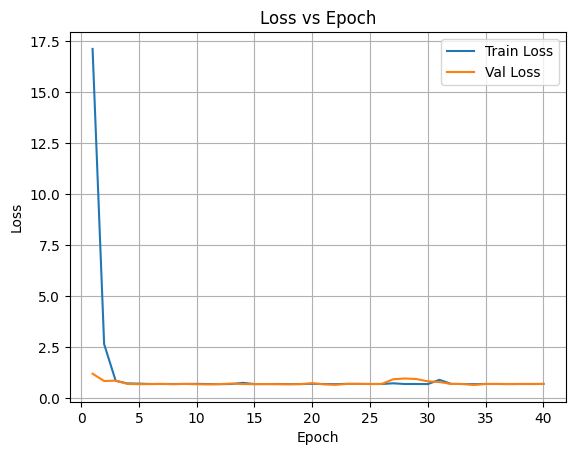

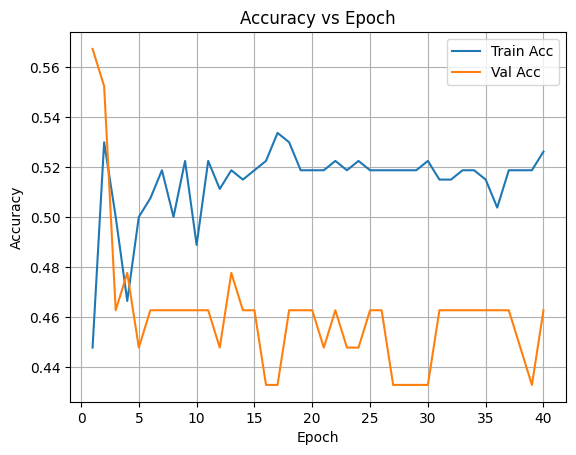

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = REAL, True = REAL
aqhbszcpal.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = REAL, True = REAL
chnbexdyhq.pt: Predicted = REAL, True = REAL
cmbloezomc.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
cuewtjauyi.pt: Predict

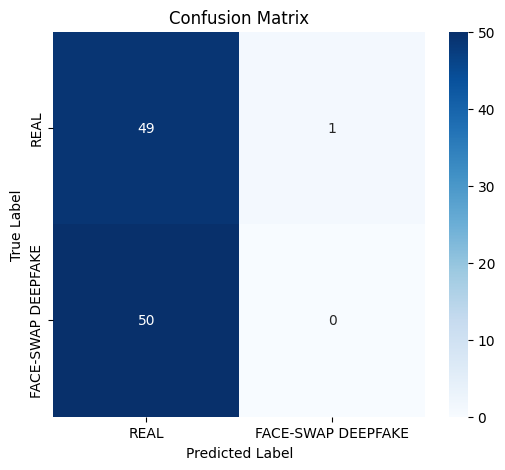


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.49      0.98      0.66        50
FACE-SWAP DEEPFAKE       0.00      0.00      0.00        50

          accuracy                           0.49       100
         macro avg       0.25      0.49      0.33       100
      weighted avg       0.25      0.49      0.33       100


📈 AUC Score: 0.5204


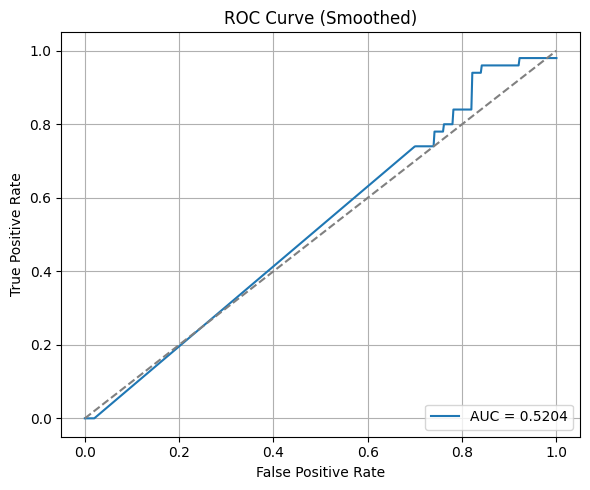

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = CustomizedCNN()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/CNN_Customized_128Filter_LR1e-3.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")